## Example 5: Extractive Distillation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
import utils.AntoineEquation as AE
from IPython.display import clear_output
from tqdm import tqdm
from distillation.DistillationDoubleFeed import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output
from thermo_models.VanLaarModel import *
from distillation.residue_curves import *

In [2]:
#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Kanapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Create a Raoult's law object
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])


c:\Users\kelle\newCTEI\ctei_ext_distillation\src\thermo_models\VLEModelBaseClass.py:197: RuntimeWarning: overflow encountered in multiply
  lhs = x_array * self.get_activity_coefficient(x_array, Temp=Temp) * self.get_vapor_pressure(Temp)
c:\Users\kelle\newCTEI\ctei_ext_distillation\src\thermo_models\VLEModelBaseClass.py:197: RuntimeWarning: overflow encountered in multiply
  lhs = x_array * self.get_activity_coefficient(x_array, Temp=Temp) * self.get_vapor_pressure(Temp)


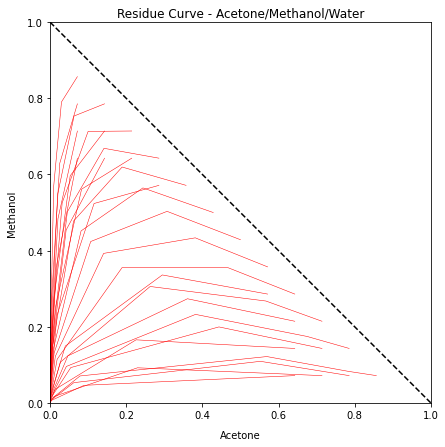

In [3]:
out_residue = Output()
rcm = residue_curve(AceMethWaterSys)
fig, ax = plt.subplots(1,1,figsize= (7,7))
rcm.plot_residue_curve_og(ax,15)